In [ ]:
!pip install kaggle

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
import os
from PIL import Image, ImageDraw
import torchvision.transforms as transforms
import cv2
import numpy as np
import pandas as pd

In [ ]:
od.download("https://www.kaggle.com/c/abide/data")

Skipping, found downloaded files in "./abide" (use force=True to force download)


In [ ]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
import time
import sklearn

In [ ]:
pheno_train = pd.read_csv('/content/abide/comp_data/pheno_train.csv')
pheno_test = pd.read_csv('/content/abide/comp_data/pheno_test.csv')
ss = pd.read_csv('/content/abide/comp_data/sample_submission.csv')
func = h5py.File('/content/abide/comp_data/abide.hdf5', 'r')

# adjust according to submission format
pheno_train['DX_GROUP'] = pheno_train['DX_GROUP'] - 1.0

In [ ]:
def get_data_train(data, pheno, derivative):
    X = []
    y = []
    i = 0
    total = pheno.shape[0]
    for row in pheno.iterrows():
        file_id, dx_group = row[1]['FILE_ID'], row[1]['DX_GROUP']
        connectivity = data['patients'][file_id][derivative][()]
        X.append(connectivity)
        y.append(dx_group)
        sys.stdout.write("\r{:.2f}%>".format(i/total))
        sys.stdout.flush()
        i += 1
        
    X = np.array(X).astype(np.float32)
    y = np.array(y).astype(np.float32)
    return X, y

def get_data_test(data, pheno, derivative):
    X_test = []
    sub_ids = []
    j = 0
    total = pheno.shape[0]
    for row in pheno.iterrows():
        file_id, sub_id = row[1]['FILE_ID'], row[1]['SUB_ID']
        connectivity = data['patients'][file_id][derivative][()]
        X_test.append(connectivity)
        sub_ids.append(sub_id)
        sys.stdout.write("\r{:.2f}%>".format(j/total))
        sys.stdout.flush()
        j += 1
        
    X_test = np.array(X_test).astype(np.float32)
    return X_test, sub_ids

In [ ]:
X, y = get_data_train(func, pheno_train, 'aal')
print(X.shape, y.shape)

1.00%>(931, 6670) (931,)


In [ ]:
pd.DataFrame(y).value_counts()

1.0    477
0.0    454
dtype: int64

In [ ]:
X_test, sub_ids = get_data_test(func, pheno_test, 'aal')
print(X_test.shape, len(sub_ids))


0.99%>(104, 6670) 104


In [ ]:
X= X.reshape(X.shape[0],X.shape[1],1)

In [ ]:
import tensorflow as tf
from tensorflow import nn
from tensorflow import keras
from tensorflow.python.keras.layers import Input, Dense, Dropout,Conv1D,MaxPooling1D,Activation,Flatten,AveragePooling1D,GlobalMaxPooling1D,ZeroPadding1D, BatchNormalization, GlobalAveragePooling1D
from tensorflow.python.keras.models import Sequential
from tensorflow import keras
from keras import layers

In [ ]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

In [ ]:
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [ ]:
model = Sequential()
model.add(layer=Conv1D(filters=3, kernel_size=11, activation='tanh',data_format='channels_last',padding='same'))
model.add(layer=Conv1D(filters=8, kernel_size=9, activation='swish',data_format='channels_last',padding='same'))
model.add(layer=AveragePooling1D(pool_size=2))
model.add(layer=Dropout(rate=0.25))
model.add(layer=Flatten())

In [ ]:
train = model.predict(X)
print(train.shape)

(931, 26680)


In [ ]:
target_train = y

In [ ]:
from imblearn.over_sampling import RandomOverSampler

OS = RandomOverSampler(sampling_strategy='auto', random_state=0)
X_ros, y_ros = OS.fit_resample(train, target_train)
print(X_ros.shape, y_ros.shape)

(954, 26680) (954,)


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='not minority',random_state=10)
X_sm, y_sm = smote.fit_resample(train, target_train)
print(X_sm.shape, y_sm.shape)

(931, 26680) (931,)


In [ ]:
df5 = pd.concat([pd.DataFrame(X_sm),pd.DataFrame(X_ros)])
print(df5.shape)
target5 = pd.concat([pd.DataFrame(y_sm),pd.DataFrame(y_ros)])
print(target5.shape)

(1885, 26680)
(1885, 1)


In [ ]:
pd.DataFrame(target5).value_counts()

1.0    954
0.0    931
dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_trainsm, X_testsm, y_trainsm, y_testsm = train_test_split(np.array(df5 ), np.array(target5) , test_size=0.10, random_state=21)
print(X_trainsm.shape, X_testsm.shape, y_trainsm.shape, y_testsm.shape)

(1696, 26680) (189, 26680) (1696, 1) (189, 1)


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [ ]:
RandomForest=RandomForestClassifier(max_depth=200,max_features=10000,min_samples_leaf=3,min_samples_split=12,n_estimators=90)
RandomForest.fit(X_trainsm, y_trainsm)
y_pred_trainsm_rnd = RandomForest.predict(X_trainsm)
y_predsm_rnd = RandomForest.predict(X_testsm)
accuracy_trainsm = accuracy_score(y_trainsm, y_pred_trainsm_rnd)
accuracysm = accuracy_score(y_testsm, y_predsm_rnd)
print("Accuracysm of random_forest: %.2f%%" % (accuracysm * 100.0))
print("Accuracy trainsm of random_forest: %.2f%%" % (accuracy_trainsm * 100.0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracysm of random_forest: 96.83%
Accuracy trainsm of random_forest: 100.00%


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
cv_results = cross_validate(RandomForest,X_trainsm, y_trainsm, cv=10)
sorted(cv_results.keys())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

['fit_time', 'score_time', 'test_score']

In [ ]:
cv_results['test_score']

array([0.92352941, 0.94117647, 0.97058824, 0.88823529, 0.97058824,
       0.93529412, 0.95857988, 0.95857988, 0.89940828, 0.92307692])

In [ ]:
!pip install scikit-plot

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=2)

#Train the model using the training sets
knn.fit(X_trainsm, y_trainsm)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=2)

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
cv_results = cross_validate(knn,X_trainsm, y_trainsm, cv=10)
sorted(cv_results.keys())

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

['fit_time', 'score_time', 'test_score']

In [ ]:
cv_results['test_score']

array([0.78235294, 0.79411765, 0.77647059, 0.74117647, 0.77058824,
       0.81764706, 0.79289941, 0.81656805, 0.79289941, 0.78698225])

In [ ]:
from sklearn.cluster import MiniBatchKMeans
n_clusters=2 
minibatch_kmeans = MiniBatchKMeans(n_clusters)
minibatch_kmeans.fit(X_trainsm)
from sklearn.metrics import silhouette_score
print(f'silhouette_score for {n_clusters} of cluster',silhouette_score(X_trainsm, minibatch_kmeans.labels_))


silhouette_score for 2 of cluster 0.025563817


In [ ]:
from sklearn import metrics
y_pred = knn.predict(X_trainsm)
y_pred_test = knn.predict(X_testsm)
print("Accuracy for train set:",metrics.accuracy_score(y_trainsm, y_pred))
print("Accuracy for test set:",metrics.accuracy_score(y_testsm, y_pred_test))

Accuracy for train set: 0.9805424528301887
Accuracy for test set: 0.8148148148148148


In [ ]:
probas = knn.predict_proba(X_testsm)

In [ ]:
y_testsm = y_testsm.reshape(y_testsm.shape[0])
y_predsm =y_pred_test.reshape(y_pred_test.shape[0])
print(y_testsm.shape,y_predsm.shape)


(189,) (189,)


In [ ]:
!pip install scikit-plot

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

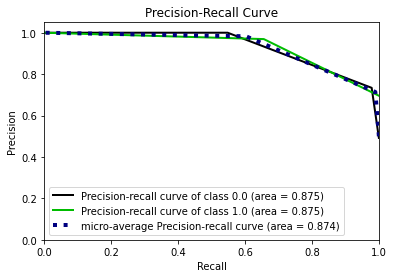

In [ ]:
skplt.metrics.plot_precision_recall(y_testsm,probas)

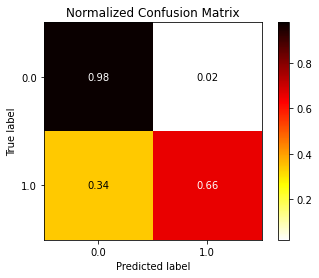

In [ ]:
skplt.metrics.plot_confusion_matrix(y_testsm,y_predsm, normalize=True, cmap='hot_r')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


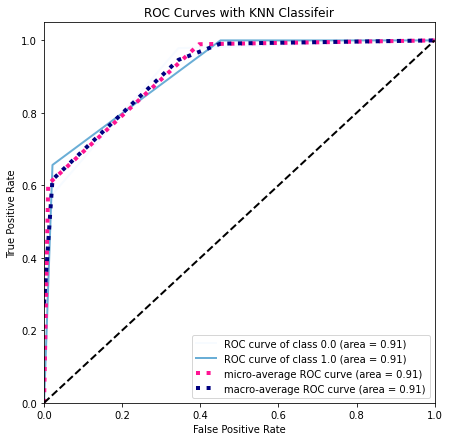

In [ ]:
skplt.metrics.plot_roc_curve(y_testsm,probas,title="ROC Curves with KNN Classifeir", cmap='Blues', figsize=[7,7])
plt.show()

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

In [ ]:
probas = RandomForest.predict_proba(X_testsm)

In [ ]:
y_testsm = y_testsm.reshape(y_testsm.shape[0])
y_predsm = y_predsm_rnd.reshape(y_testsm.shape[0])
print(y_testsm.shape,y_predsm.shape)


(189,) (189,)


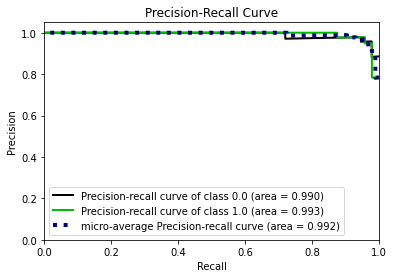

In [ ]:
skplt.metrics.plot_precision_recall(y_testsm,probas)

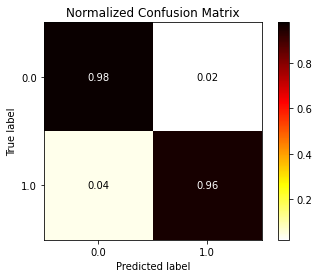

In [ ]:
skplt.metrics.plot_confusion_matrix(y_testsm,y_predsm, normalize=True, cmap='hot_r')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


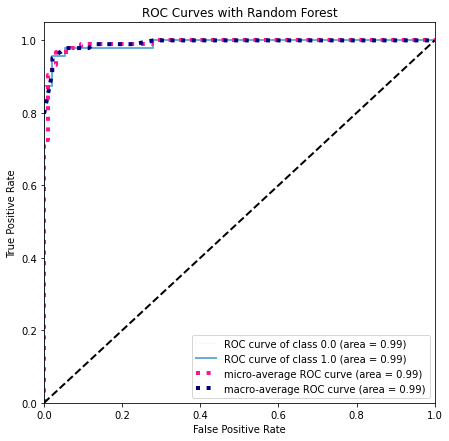

In [ ]:
skplt.metrics.plot_roc_curve(y_testsm,probas,title="ROC Curves with Random Forest", cmap='Blues', figsize=[7,7])
plt.show()

In [ ]:
from xgboost import XGBClassifier

In [ ]:
model=XGBClassifier(n_estimators=20,max_depth=40,learning_rate=0.8)

In [ ]:
model.fit(X_trainsm, y_trainsm)
y_pred_trainsm = model.predict(X_trainsm)
y_predsm = model.predict(X_testsm)
accuracy_trainsm = accuracy_score(y_trainsm, y_pred_trainsm)
accuracysm = accuracy_score(y_testsm, y_predsm)
print("Accuracysm: %.2f%%" % (accuracysm * 100.0))
print("Accuracy trainsm: %.2f%%" % (accuracy_trainsm * 100.0))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracysm: 94.71%
Accuracy trainsm: 100.00%


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
cv_results = cross_validate(model,X_trainsm, y_trainsm, cv=10)
sorted(cv_results.keys())

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

['fit_time', 'score_time', 'test_score']

In [ ]:
cv_results['test_score']

array([0.94705882, 0.94117647, 0.93529412, 0.87058824, 0.94117647,
       0.89411765, 0.9408284 , 0.94674556, 0.9112426 , 0.92307692])

In [ ]:
probas = model.predict_proba(X_testsm)

In [ ]:
y_testsm = y_testsm.reshape(y_testsm.shape[0])
y_predsm = y_predsm.reshape(y_testsm.shape[0])
print(y_testsm.shape,y_predsm.shape)


(189,) (189,)


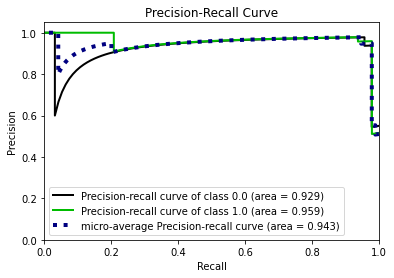

In [ ]:
skplt.metrics.plot_precision_recall(y_testsm,probas)

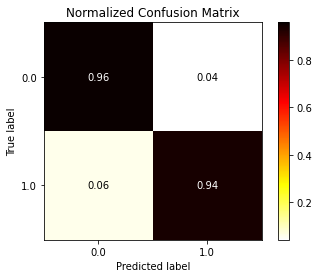

In [ ]:
skplt.metrics.plot_confusion_matrix(y_testsm,y_predsm, normalize=True, cmap='hot_r')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


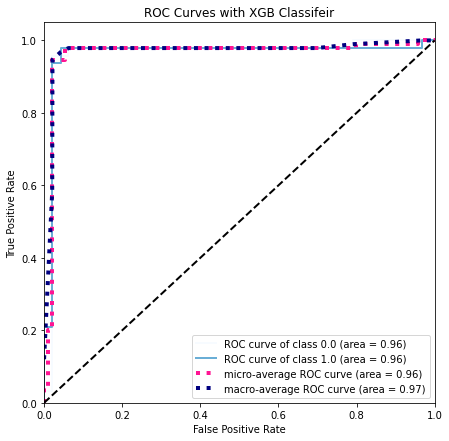

In [ ]:
skplt.metrics.plot_roc_curve(y_testsm,probas,title="ROC Curves with XGB Classifeir", cmap='Blues', figsize=[7,7])
plt.show()

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm_model=SVC(C=3.4000000000000004, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=2, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
svm_model.fit(X_trainsm, y_trainsm)
y_pred_trainsm_rnd =svm_model.predict(X_trainsm)
y_predsm_rnd = svm_model.predict(X_testsm)
accuracy_trainsm = accuracy_score(y_trainsm, y_pred_trainsm_rnd)
accuracysm = accuracy_score(y_testsm, y_predsm_rnd)
print("Accuracysm TEST of SVM: %.2f%%" % (accuracysm * 100.0))
print("Accuracy trainsm of SVM: %.2f%%" % (accuracy_trainsm * 100.0))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracysm TEST of SVM: 96.83%
Accuracy trainsm of SVM: 100.00%


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
cv_results = cross_validate(svm_model,X_trainsm, y_trainsm, cv=10)
sorted(cv_results.keys())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

['fit_time', 'score_time', 'test_score']

In [ ]:
cv_results['test_score']

array([0.92941176, 0.92941176, 0.94705882, 0.90588235, 0.95294118,
       0.94705882, 0.96449704, 0.9408284 , 0.92307692, 0.92899408])

In [ ]:
y_testsm = y_testsm.reshape(y_testsm.shape[0])
y_predsm = y_predsm_rnd.reshape(y_testsm.shape[0])
print(y_testsm.shape,y_predsm.shape)


(189,) (189,)


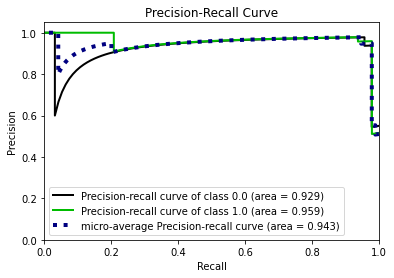

In [ ]:
skplt.metrics.plot_precision_recall(y_testsm,probas)

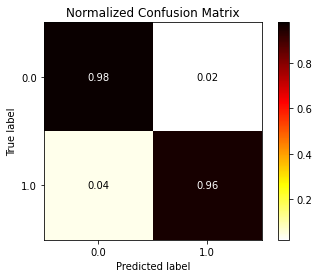

In [ ]:
skplt.metrics.plot_confusion_matrix(y_testsm,y_predsm, normalize=True, cmap='hot_r')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


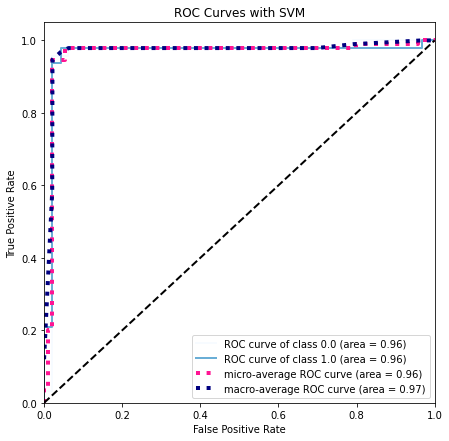

In [ ]:
skplt.metrics.plot_roc_curve(y_testsm,probas,title="ROC Curves with SVM", cmap='Blues', figsize=[7,7])
plt.show()